The second edition of *Think DSP* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Discrete Fourier Transform

We've been using the discrete Fourier transform (DFT) since Chapter 1, but I haven't explained how it works.
Now is the time.

If you understand the discrete cosine transform (DCT), you will understand the DFT.
The only difference is that instead of using the cosine function, we'll use the complex exponential function.
I'll start by explaining complex exponentials, then I'll follow the same progression as in Chapter 6:

1.  We'll start with the synthesis problem: given a set of frequency components and their amplitudes, how can we construct a signal? The synthesis problem is equivalent to the inverse DFT.

2.  Then I'll rewrite the synthesis problem in the form of matrix multiplication using NumPy arrays.

3.  Next we'll solve the analysis problem, which is equivalent to the DFT: given a signal, how to we find the amplitude and phase offset of its frequency components?

4.  Finally, we'll use linear algebra to find a more efficient way to compute the DFT.


[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkDSP/blob/v2/nb/chap01.ipynb).

In [1]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP/raw/v2/nb/thinkdsp.py")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import thinkdsp
from thinkdsp import decorate, decorate_time, decorate_freq, decorate_power, decorate_gram

PI2 = 2 * np.pi

## Complex exponentials

One of the more interesting moves in mathematics is the generalization of an operation from one type to another.
For example, factorial naturally operates on integers -- the factorial of $n$ is the product of all integers from 1 to $n$.

If you are of a certain inclination, you might wonder how to compute the factorial of a non-integer like 3.5. Since the natural definition doesn't apply, you might look for other ways to compute the factorial function, ways that would work with non-integers.

In 1730, Leonhard Euler found one, a generalization of the factorial function that we know as the gamma function.
Euler also found one of the most useful generalizations in applied mathematics, the complex exponential function.

The natural definition of exponentiation is repeated multiplication.
For example, $\phi^3 = \phi \cdot \phi \cdot \phi$.
But this definition doesn't apply to non-integer exponents.

However, exponentiation can also be expressed as a power series:

$$e^\phi = 1 + \phi + \phi^2/2! + \phi^3/3! + ...$$

This definition works with real numbers, imaginary numbers and, by a simple extension, with complex numbers.
Applying this definition to a pure imaginary number, $i\phi$, we get:

$$e^{i\phi} = 1 + i\phi - \phi^2/2! - i\phi^3/3! + ...$$

By rearranging terms, we can show that this is equivalent to:

$$e^{i\phi} = \cos \phi + i \sin \phi$$

You can see the derivation at <http://en.wikipedia.org/wiki/Euler's_formula>.

This formula implies that $e^{i\phi}$ is a complex number with magnitude 1; if you think of it as a point in the complex plane, it is always on the unit circle.
And if you think of it as a vector, the angle in radians between the vector and the positive x-axis is the argument, $\phi$.

In the case where the exponent is a complex number, we have:

$$e^{a + i\phi} = e^a e^{i\phi} = A e^{i\phi}$$

where $A$ is a real number that indicates magnitude and $e^{i\phi}$ is a unit complex number that indicates angle.

NumPy provides a version of `exp` that works with complex numbers:

In [3]:
phi = 1.5
z = np.exp(1j * phi)
z

np.complex128(0.0707372016677029+0.9974949866040544j)

Python uses `j` to represent the imaginary unit, rather than `i`.
A number ending in `j` is considered imaginary, so `1j` represents $i$.

When the argument to `np.exp` is imaginary or complex, the result is a complex number; specifically, a `np.complex128`, which is represented by two 64-bit floating-point numbers.
In this example, the result is `0.0707+0.997j`.

Complex numbers have attributes `real` and `imag`:

In [4]:
z.real, z.imag

(np.float64(0.0707372016677029), np.float64(0.9974949866040544))

To get the magnitude, you can use the built-in function `abs` or `np.absolute`:

In [5]:
abs(z), np.absolute(z)

(np.float64(1.0), np.float64(1.0))

To get the angle, you can use `np.angle`:

In [6]:
np.angle(z)

np.float64(1.5)

This example confirms that $e^{i \phi}$ is a complex number with magnitude 1 and angle $\phi$ radians.

## Complex signals

If $\phi(t)$ is a function of time, $e^{i \phi(t)}$ is also a function of time.
Specifically:

$$e^{i \phi(t)} = \cos \phi(t) + i \sin \phi(t)$$

This function describes a quantity that varies in time, so it is a signal.
Specifically, it is a **complex exponential signal**.

In the special case where the frequency of the signal is constant, $\phi(t)$ is $2 \pi f t$ and the result is a **complex sinusoid**:

$$e^{i 2 \pi f t} = \cos 2 \pi f t + i \sin 2 \pi f t$$

Or more generally, the signal might start at a phase offset $\phi_0$, yielding:

$$e^{i (2 \pi f t + \phi_0)}$$

`thinkdsp` provides an implementation of this signal, `ComplexSinusoid`:

In [7]:
from thinkdsp import Sinusoid

class ComplexSinusoid(Sinusoid):

    def evaluate(self, ts):
        phases = PI2 * self.freq * ts + self.offset
        ys = self.amp * np.exp(1j * phases)
        return ys

`ComplexSinusoid` inherits `__init__` from `Sinusoid`.
It provides a version of `evaluate` that is almost identical to `Sinusoid.evaluate`; the only difference is that it uses `np.exp` instead of `np.sin`.

The result is a NumPy array of complex numbers:

In [8]:
signal = thinkdsp.ComplexSinusoid(freq=1, amp=0.6, offset=1)
wave = signal.make_wave(duration=1, framerate=4)
wave.ys

array([ 0.32418138+0.50488259j, -0.50488259+0.32418138j,
       -0.32418138-0.50488259j,  0.50488259-0.32418138j])

The frequency of this signal is 1 cycle per second, the amplitude is 0.6 (in unspecified units), and the phase offset is 1 radian.

This example evaluates the signal at 4 places equally spaced between 0 and 1 second.
The resulting samples are complex numbers.

## The synthesis problem

Just as we did with real sinusoids, we can create compound signals by adding up complex sinusoids with different frequencies.
And that brings us to the complex version of the synthesis problem: given the frequency and amplitude of each complex component, how do we evaluate the signal?

The simplest solution is to create `ComplexSinusoid` objects and add them up.

In [9]:
from thinkdsp import SumSignal

def synthesize1(amps, fs, ts):
    components = [thinkdsp.ComplexSinusoid(freq, amp)
                  for amp, freq in zip(amps, fs)]
    signal = thinkdsp.SumSignal(*components)
    ys = signal.evaluate(ts)
    return ys

This function is almost identical to `synthesize1` in Section [\[synth1\]](#synth1){reference-type="ref" reference="synth1"}; the only difference is that I replaced `CosSignal` with `ComplexSinusoid`.

Here's an example:

In [10]:
amps = np.array([0.6, 0.25, 0.1, 0.05])
fs = [100, 200, 300, 400]
framerate = 11025
ts = np.linspace(0, 1, framerate, endpoint=False)
ys = synthesize1(amps, fs, ts)
ys

array([1.        +0.j        , 0.99465216+0.09092275j,
       0.9787423 +0.18028474j, ..., 0.95266642-0.26657509j,
       0.9787423 -0.18028474j, 0.99465216-0.09092275j])

At the lowest level, a complex signal is a sequence of complex numbers.
But how should we interpret it? We have some intuition for real signals: they represent quantities that vary in time; for example, a sound signal represents changes in air pressure.
But nothing we measure in the world yields complex numbers.

So what is a complex signal? I don't have a satisfying answer to this question.
The best I can offer is two unsatisfying answers:

1.  A complex signal is a mathematical abstraction that is useful for computation and analysis, but it does not correspond directly with anything in the real world.

2.  If you like, you can think of a complex signal as a sequence of complex numbers that contains two signals as its real and imaginary parts.

Taking the second point of view, we can split the previous signal into its real and imaginary parts:

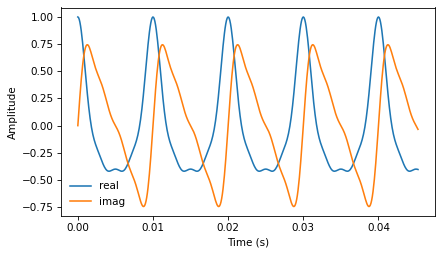

In [11]:
n = 500
plt.plot(ts[:n], ys[:n].real, label='real')
plt.plot(ts[:n], ys[:n].imag, label='imag')
decorate_time()

The following figure shows a segment of the result.
The real part is a sum of cosines; the imaginary part is a sum of sines.
Although the waveforms look different, they contain the same frequency components in the same proportions.
To our ears, they sound the same (in general, we don't hear phase offsets).

## Synthesis with matrices

As we saw in Section xxx, we can also express the synthesis problem in terms of matrix multiplication:

In [12]:
def synthesize2(amps, fs, ts):
    args = np.outer(ts, fs)
    M = np.exp(1j * PI2 * args)
    ys = np.dot(M, amps)
    return ys

Again, `amps` is a NumPy array that contains a sequence of amplitudes.

`fs` is a sequence containing the frequencies of the components.
`ts` contains the times where we will evaluate the signal.

`args` contains the outer product of `ts` and `fs`, with the `ts` running down the rows and the `fs` running across the columns (you might want to refer back to the earlier figure).

Each column of matrix `M` contains a complex sinusoid with a particular frequency, evaluated at a sequence of `ts`.

When we multiply `M` by the amplitudes, the result is a vector whose elements correspond to the `ts`; each element is the sum of several complex sinusoids, evaluated at a particular time.

Here's the example from the previous section again:

In [13]:
ys = synthesize2(amps, fs, ts)
ys

array([1.        +0.j        , 0.99465216+0.09092275j,
       0.9787423 +0.18028474j, ..., 0.95266642-0.26657509j,
       0.9787423 -0.18028474j, 0.99465216-0.09092275j])

The result is the same.

In this example the amplitudes are real, but they could also be complex.
What effect does a complex amplitude have on the result? Remember that we can think of a complex number in two ways: either the sum of a real and imaginary part, $x + i y$, or the product of a real amplitude and a complex exponential, $A e^{i \phi_0}$.
Using the second interpretation, we can see what happens when we multiply a complex amplitude by a complex sinusoid.
For each frequency, $f$, we have:

$$A \exp{i \phi_0} \cdot \exp{i 2 \pi f t} = A \exp{i (2 \pi f t + \phi_0)}$$

Multiplying by $A e^{i \phi_0}$ multiplies the amplitude by $A$ and adds the phase offset $\phi_0$.

We can test that claim by running the previous example with $\phi_0 = 1.5$ for all frequency components:

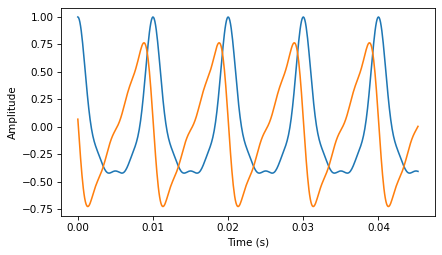

In [14]:
phi = 1.5
amps2 = amps * np.exp(1j * phi)
ys2 = synthesize2(amps2, fs, ts)

plt.plot(ts[:n], ys.real[:n])
plt.plot(ts[:n], ys2.real[:n])
decorate_time()

Since `amps` is an array of reals, multiplying by `np.exp(1j * phi)` yields an array of complex numbers with phase offset `phi` radians, and the same magnitudes as `amps`.

The following figure shows the result.
The phase offset $\phi_0 = 1.5$ shifts the wave to the left by about one quarter of a cycle; it also changes the waveform, because the same phase offset applied to different frequencies changes how the frequency components line up with each other.

Now that we have the more general solution to the synthesis problem -- one that handles complex amplitudes -- we are ready for the analysis problem.

## The analysis problem

The analysis problem is the inverse of the synthesis problem: given a sequence of samples, $y$, and knowing the frequencies that make up the signal, can we compute the complex amplitudes of the components, $a$?

As we saw in Section [\[analysis\]](#analysis){reference-type="ref" reference="analysis"}, we can solve this problem by forming the synthesis matrix, $M$, and solving the system of linear equations, $M a = y$ for $a$.

In [15]:
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.exp(1j * PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

`analyze1` takes a (possibly complex) wave array, `ys`, a sequence of real frequencies, `fs`, and a sequence of real times, `ts`.
It returns a sequence of complex amplitudes, ` amps`.

Continuing the previous example, we can confirm that `analyze1` recovers the amplitudes we started with.
For the linear system solver to work, `M` has to be square, so we need `ys`, ` fs` and `ts` to have the same length.
I'll insure that by slicing `ys` and `ts` down to the length of `fs`:

In [16]:
n = len(fs)
amps2 = analyze1(ys[:n], fs, ts[:n])
amps2

array([0.6 -4.54219995e-14j, 0.25+1.38208889e-13j, 0.1 -1.38545425e-13j,
       0.05+4.57169025e-14j])

These are approximately the amplitudes we started with, although each component has a small imaginary part due to floating-point errors.

## Efficient analysis

Unfortunately, solving a linear system of equations is slow.
For the DCT, we were able to speed things up by choosing `fs` and ` ts` so that `M` is orthogonal.
That way, the inverse of `M` is the transpose of `M`, and we can compute both DCT and inverse DCT by matrix multiplication.

We'll do the same thing for the DFT, with one small change.
Since `M` is complex, we need it to be **unitary**, rather than orthogonal, which means that the inverse of `M` is the conjugate transpose of `M`, which we can compute by transposing the matrix and negating the imaginary part of each element.
See <http://en.wikipedia.org/wiki/Unitary_matrix>.

The NumPy methods `conj` and `transpose` do what we want.
Here's the code that computes `M` for $N=4$ components:

In [17]:
N = 4
ts = np.arange(N) / N
fs = np.arange(N)
args = np.outer(ts, fs)
M = np.exp(1j * PI2 * args)

If $M$ is unitary, $M^*M = I$, where $M^*$ is the conjugate transpose of $M$, and $I$ is the identity matrix.
We can test whether $M$ is unitary like this:

In [18]:
MstarM = M.conj().T @ M
MstarM

array([[ 4.00000000e+00+0.00000000e+00j, -1.83697020e-16+2.22044605e-16j,
         0.00000000e+00+2.44929360e-16j,  3.29046455e-16+3.33066907e-16j],
       [-1.83697020e-16-2.22044605e-16j,  4.00000000e+00+0.00000000e+00j,
        -1.72254642e-16+1.33907057e-16j,  0.00000000e+00+2.44929360e-16j],
       [ 0.00000000e+00-2.44929360e-16j, -1.72254642e-16-1.33907057e-16j,
         4.00000000e+00+0.00000000e+00j, -8.41170949e-17+1.99159850e-16j],
       [ 3.29046455e-16-3.33066907e-16j,  0.00000000e+00-2.44929360e-16j,
        -8.41170949e-17-1.99159850e-16j,  4.00000000e+00+0.00000000e+00j]])

The result, within the tolerance of floating-point error, is $4 I$, so $M$ is unitary except for an extra factor of $N$, similar to the extra factor of 2 we found with the DCT.

We can use this result to write a faster version of `analyze1`:

In [19]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.exp(1j * PI2 * args)
    amps = M.conj().transpose().dot(ys) / N
    return amps

And test it with appropriate values of `fs` and `ts`:

In [20]:
N = 4
amps = np.array([0.6, 0.25, 0.1, 0.05])
fs = np.arange(N)
ts = np.arange(N) / N
ys = synthesize2(amps, fs, ts)
amps3 = analyze2(ys, fs, ts)
amps3

array([0.6 +1.38777878e-17j, 0.25+6.12323400e-18j, 0.1 -3.67394040e-17j,
       0.05-8.44960014e-17j])

## DFT

As a function, `analyze2` would be hard to use because it only works if `fs` and `ts` are chosen correctly.
Instead, I will rewrite it to take just `ys` and compute `fs` and `ts` itself.

First, I'll make a function to compute the synthesis matrix, $M$:

In [21]:
def synthesis_matrix(N):
    ts = np.arange(N) / N
    fs = np.arange(N)
    args = np.outer(ts, fs)
    M = np.exp(1j * PI2 * args)
    return M

Then I'll write the function that takes `ys` and returns `amps`:

In [22]:
def analyze3(ys):
    N = len(ys)
    M = synthesis_matrix(N)
    amps = M.conj().transpose().dot(ys) / N
    return amps

We are almost done; `analyze3` computes something very close to the DFT, with one difference.
The conventional definition of DFT does not divide by `N`:

In [23]:
def dft(ys):
    N = len(ys)
    M = synthesis_matrix(N)
    amps = M.conj().transpose().dot(ys)
    return amps

Now we can confirm that my version yields the same result as FFT:

In [24]:
dft(ys)

array([2.4+5.55111512e-17j, 1. +2.44929360e-17j, 0.4-1.46957616e-16j,
       0.2-3.37984006e-16j])

The result is close to `amps * N`. And here's the version in `np.fft`:

In [25]:
np.fft.fft(ys)

array([2.4+5.22485116e-17j, 1. -2.44929360e-17j, 0.4-3.26263963e-18j,
       0.2-2.44929360e-17j])

They are the same, within floating point error.

The inverse DFT is almost the same, except we don't have to transpose and conjugate $M$, and *now* we have to divide through by N:

In [26]:
def idft(amps):
    N = len(amps)
    M = synthesis_matrix(N)
    ys = M.dot(amps) / N
    return ys

Finally, we can confirm that `dft(idft(amps))` yields `amps`.

In [27]:
ys = idft(amps)
dft(ys)

array([0.6 +1.38777878e-17j, 0.25+6.12323400e-18j, 0.1 -3.67394040e-17j,
       0.05-8.44960014e-17j])

If I could go back in time, I might change the definition of DFT so it divides by $N$ and the inverse DFT doesn't.
That would be more consistent with my presentation of the synthesis and analysis problems.

Or I might change the definitions so that both operations divide through by $\sqrt{N}$.
Then the DFT and inverse DFT would be symmetric.

But I can't go back in time (yet!), so we're stuck with a slightly weird convention.
For practical purposes it doesn't really matter.

## The DFT is periodic

In this chapter I presented the DFT in the form of matrix multiplication.
We compute the synthesis matrix, $M$, and the analysis matrix, $M^*$.
When we multiply $M^{*}$ by the wave array, $y$, each element of the result is the product of a row from $M^*$ and $y$, which we can write in the form of a summation:

$$DFT(y)[k] = \sum_n y[n] \exp(-2 \pi i n k / N)$$

where $k$ is an index of frequency from $0$ to $N-1$ and $n$ is an index of time from $0$ to $N-1$.
So $DFT(y)[k]$ is the $k$th element of the DFT of $y$.

Normally we evaluate this summation for $N$ values of $k$, running from 0 to $N-1$.
We *could* evaluate it for other values of $k$, but there is no point, because they start to repeat.
That is, the value at $k$ is the same as the value at $k+N$ or $k+2N$ or $k-N$, etc.

We can see that mathematically by plugging $k+N$ into the summation:

$$DFT(y)[k+N] = \sum_n y[n] \exp(-2 \pi i n (k+N) / N)$$

Since there is a sum in the exponent, we can break it into two parts:

$$DFT(y)[k+N] = \sum_n y[n] \exp(-2 \pi i n k / N)  \exp(-2 \pi i n N / N)$$

In the second term, the exponent is always an integer multiple of $2 \pi$, so the result is always 1, and we can drop it:

$$DFT(y)[k+N] = \sum_n y[n] \exp(-2 \pi i n k / N)$$

And we can see that this summation is equivalent to $DFT(y)[k]$.
So the DFT is periodic, with period $N$.
You will need this result for one of the exercises below, which asks you to implement the Fast Fourier Transform (FFT).

As an aside, writing the DFT in the form of a summation provides an insight into how it works.
If you review the diagram in Section [\[synthesis\]](#synthesis){reference-type="ref" reference="synthesis"}, you'll see that each column of the synthesis matrix is a signal evaluated at a sequence of times.
The analysis matrix is the (conjugate) transpose of the synthesis matrix, so each *row* is a signal evaluated at a sequence of times.

Therefore, each summation is the correlation of $y$ with one of the signals in the array (see Section [\[dotproduct\]](#dotproduct){reference-type="ref" reference="dotproduct"}).
That is, each element of the DFT is a correlation that quantifies the similarity of the wave array, $y$, and a complex exponential at a particular frequency.

## DFT of real signals

The Spectrum class in `thinkdsp` is based on `np.fft.rfft`, which computes the "real DFT"; that is, it works with real signals.
But the DFT as presented in this chapter is more general than that; it works with complex signals.

So what happens when we apply the "full DFT" to a real signal? Let's look at an example:

In [28]:
from thinkdsp import SawtoothSignal

signal = thinkdsp.SawtoothSignal(freq=500)
wave = signal.make_wave(duration=0.1, framerate=10000)
hs = dft(wave.ys)
amps = np.absolute(hs)

This code makes a sawtooth wave with frequency 500 Hz, sampled at framerate 10 kHz.
`hs` contains the complex DFT of the wave; `amps` contains the amplitude at each frequency.
But what frequency do these amplitudes correspond to? If we look at the body of `dft`, we see:

In [29]:
N = len(amps)
fs = np.arange(N)

It's tempting to think that these values are the right frequencies.
The problem is that `dft` doesn't know the sampling rate.
The DFT assumes that the duration of the wave is 1 time unit, so it thinks the sampling rate is $N$ per time unit.
In order to interpret the frequencies, we have to convert from these arbitrary time units back to seconds, like this:

In [30]:
framerate = wave.framerate
fs = np.arange(N) * framerate / N

With this change, the range of frequencies is from 0 to the actual framerate, 10 kHz.
Now we can plot the spectrum:

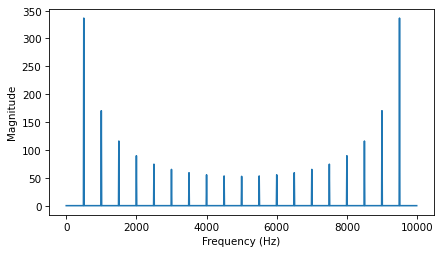

In [31]:
plt.plot(fs, amps)
decorate_freq()

This figure shows the amplitude of the signal for each frequency component from 0 to 10 kHz.
The left half of the figure is what we should expect: the dominant frequency is at 500 Hz, with harmonics dropping off like $1/f$.

But the right half of the figure is a surprise.
Past 5000 Hz, the amplitude of the harmonics start growing again, peaking at 9500 Hz. What's going on?

The answer: aliasing.
Remember that with framerate 10000 Hz, the folding frequency is 5000 Hz. As we saw in Section XXX, a component at 5500 Hz is indistinguishable from a component at 4500 Hz. When we evaluate the DFT at 5500 Hz, we get the same value as at 4500 Hz. Similarly, the value at 6000 Hz is the same as the one at 4000 Hz, and so on.

The DFT of a real signal is symmetric around the folding frequency.
Since there is no additional information past this point, we can save time by evaluating only the first half of the DFT, and that's exactly what `np.fft.rfft` does.

## Exercises

## Exercise 1

In this chapter, I showed how we can express the DFT and inverse DFT as matrix multiplications.
These operations take time proportional to $N^2$, where $N$ is the length of the wave array.
That is fast enough for many applications, but there is a faster algorithm, the Fast Fourier Transform (FFT), which takes time proportional to $N \log N$.

The key to the FFT is the Danielson-Lanczos lemma:

$DFT(y)[n] = DFT(e)[n] + \exp(-2 \pi i n / N) DFT(o)[n]$

Where $ DFT(y)[n]$ is the $n$th element of the DFT of $y$; $e$ is the even elements of $y$, and $o$ is the odd elements of $y$.

This lemma suggests a recursive algorithm for the DFT:

1. Given a wave array, $y$, split it into its even elements, $e$, and its odd elements, $o$.

2. Compute the DFT of $e$ and $o$ by making recursive calls.

3. Compute $DFT(y)$ for each value of $n$ using the Danielson-Lanczos lemma.

For the base case of this recursion, you could wait until the length of $y$ is 1.  In that case, $DFT(y) = y$.  Or if the length of $y$ is sufficiently small, you could compute its DFT by matrix multiplication, possibly using a precomputed matrix.

Hint: I suggest you implement this algorithm incrementally by starting with a version that is not truly recursive.
In Step 2, instead of making a recursive call, use `dft` or `np.fft.fft`.
Get Step 3 working, and confirm that the results are consistent with the other implementations.
Then add a base case and confirm that it works.
Finally, replace Step 2 with recursive calls.

One more hint: Remember that the DFT is periodic; you might find `np.tile` useful.

You can read more about the FFT at https://en.wikipedia.org/wiki/Fast_Fourier_transform.

As the test case, I'll start with a small real signal and compute its FFT:

In [32]:
ys = [-0.5, 0.1, 0.7, -0.1]
hs = np.fft.fft(ys)
hs

array([ 0.2+0.j , -1.2-0.2j,  0.2+0.j , -1.2+0.2j])

Here's my implementation of DFT from the book:

In [33]:
def dft(ys):
    N = len(ys)
    ts = np.arange(N) / N
    freqs = np.arange(N)
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    amps = M.conj().transpose().dot(ys)
    return amps

We can confirm that this implementation gets the same result.

In [34]:
hs2 = dft(ys)
np.sum(np.abs(hs - hs2))

np.float64(5.864775846765962e-16)

As a step toward making a recursive FFT, I'll start with a version that splits the input array and uses np.fft.fft to compute the FFT of the halves.

In [35]:
def fft_norec(ys):
    N = len(ys)
    He = np.fft.fft(ys[::2])
    Ho = np.fft.fft(ys[1::2])
    
    ns = np.arange(N)
    W = np.exp(-1j * PI2 * ns / N)
    
    return np.tile(He, 2) + W * np.tile(Ho, 2)

And we get the same results:

In [36]:
hs3 = fft_norec(ys)
np.sum(np.abs(hs - hs3))

np.float64(0.0)

Finally, we can replace `np.fft.fft` with recursive calls, and add a base case:

In [37]:
def fft(ys):
    N = len(ys)
    if N == 1:
        return ys
    
    He = fft(ys[::2])
    Ho = fft(ys[1::2])
    
    ns = np.arange(N)
    W = np.exp(-1j * PI2 * ns / N)
    
    return np.tile(He, 2) + W * np.tile(Ho, 2)

And we get the same results:

In [38]:
hs4 = fft(ys)
np.sum(np.abs(hs - hs4))

np.float64(1.6653345369377348e-16)

This implementation of FFT takes time proportional to $n \log n$.  It also takes space proportional to $n \log n$, and it wastes some time making and copying arrays.
It can be improved to run "in place"; in that case, it requires no additional space, and spends less time on overhead.

[Think DSP: Digital Signal Processing in Python, 2rd Edition](https://allendowney.github.io/ThinkDSP/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)